# 1. Data Preprocessing and Cleaning

In [44]:
# Import all required modules
import pandas as pd
pd.options.display.precision = 2

import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno
import numpy as np
from sklearn.preprocessing import StandardScaler



In [3]:
#Open cxv file and create DataFrame
df_Ecom = pd.read_csv("ECom_Github.csv", encoding='latin1')

## 1.1 Data Preprocessing

In [4]:
df_Ecom.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df_Ecom.describe()

,Quantity,UnitPrice,CustomerID
count,541909.00,541909.00,406829.00
mean,9.55,4.61,15287.69
std,218.08,96.76,1713.60
min,-80995.00,-11062.06,12346.00
25%,1.00,1.25,13953.00
50%,3.00,2.08,15152.00
75%,10.00,4.13,16791.00
max,80995.00,38970.00,18287.00


In [6]:
df_Ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## 1.2 Handling missing values

In [8]:
#Identify missing values per column
df_Ecom.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<Axes: >

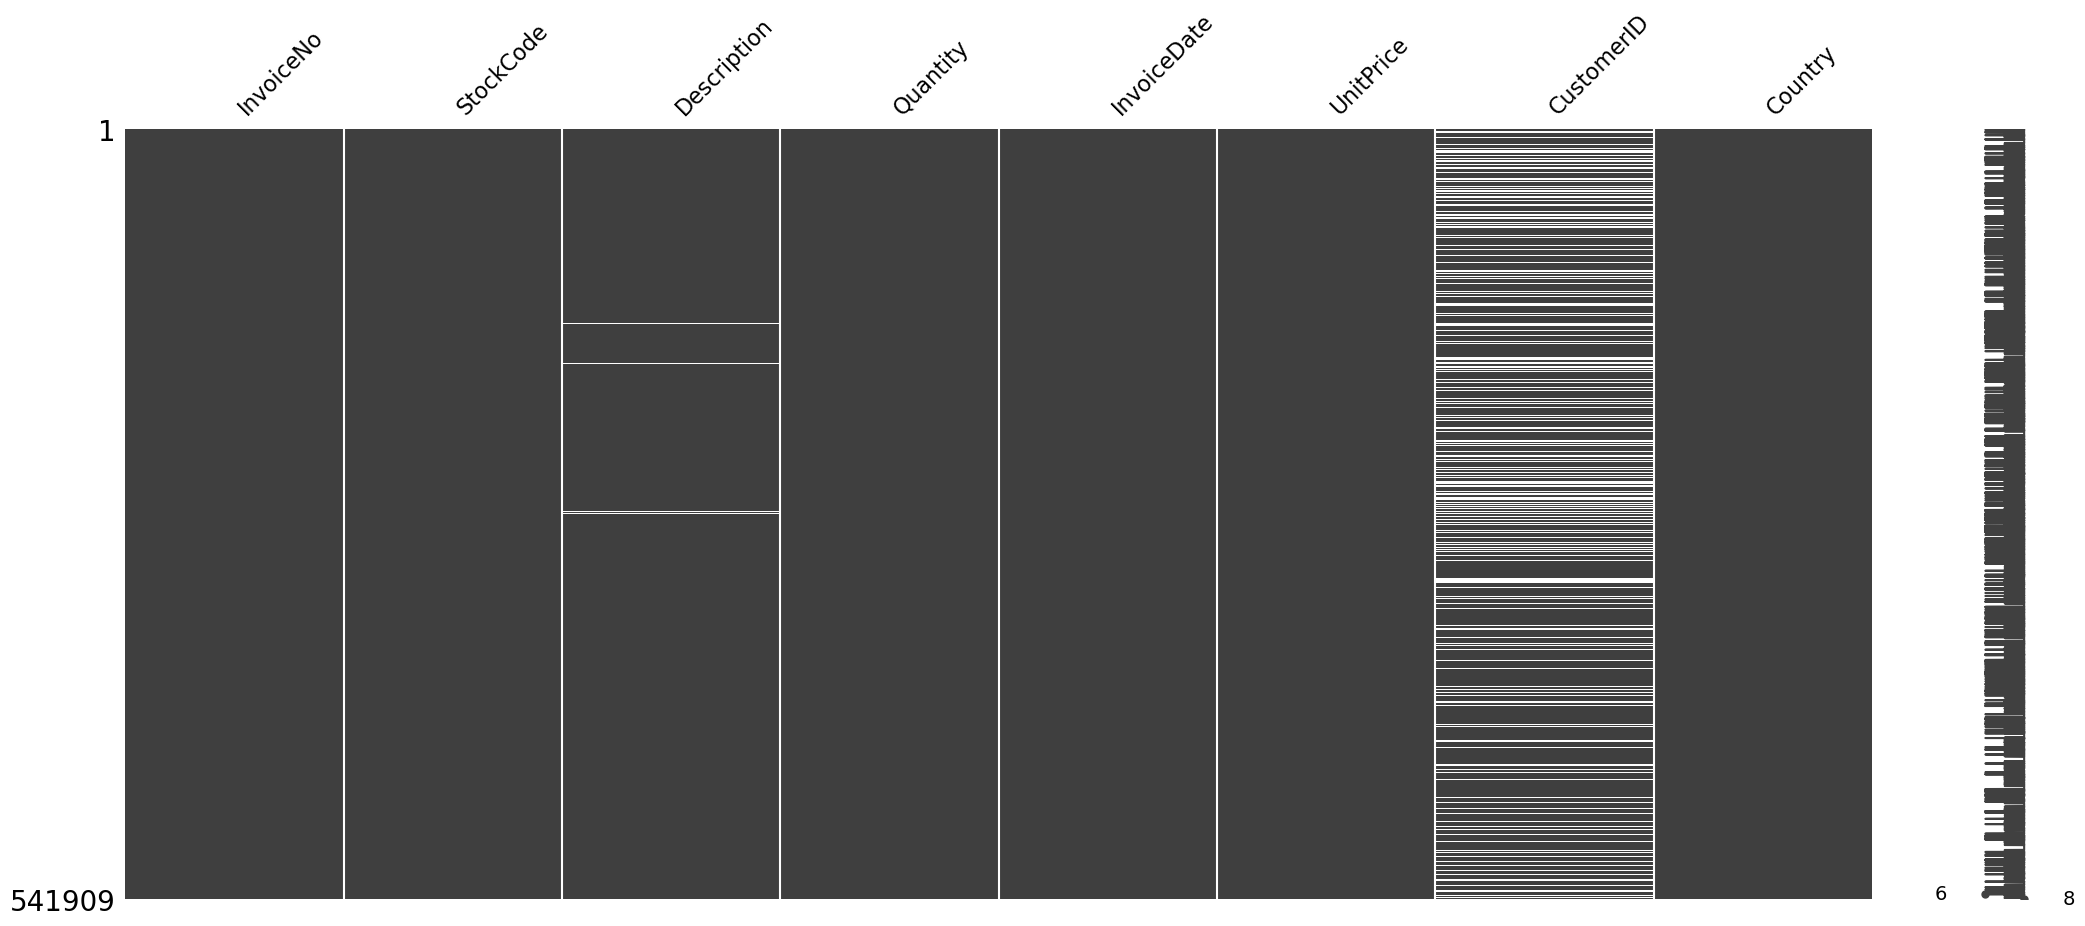

In [9]:
msno.matrix(df_Ecom)

In [11]:
missing_ratio = df_Ecom['CustomerID'].isna().mean()
print(f"{missing_ratio:.2%} of rows have missing CustomerID")

24.93% of rows have missing CustomerID


In [15]:
#Since our goal is customer segmentation we need valid customer ID
df_ECom_cleaned = df_Ecom.dropna(subset=['CustomerID'])

<Axes: >

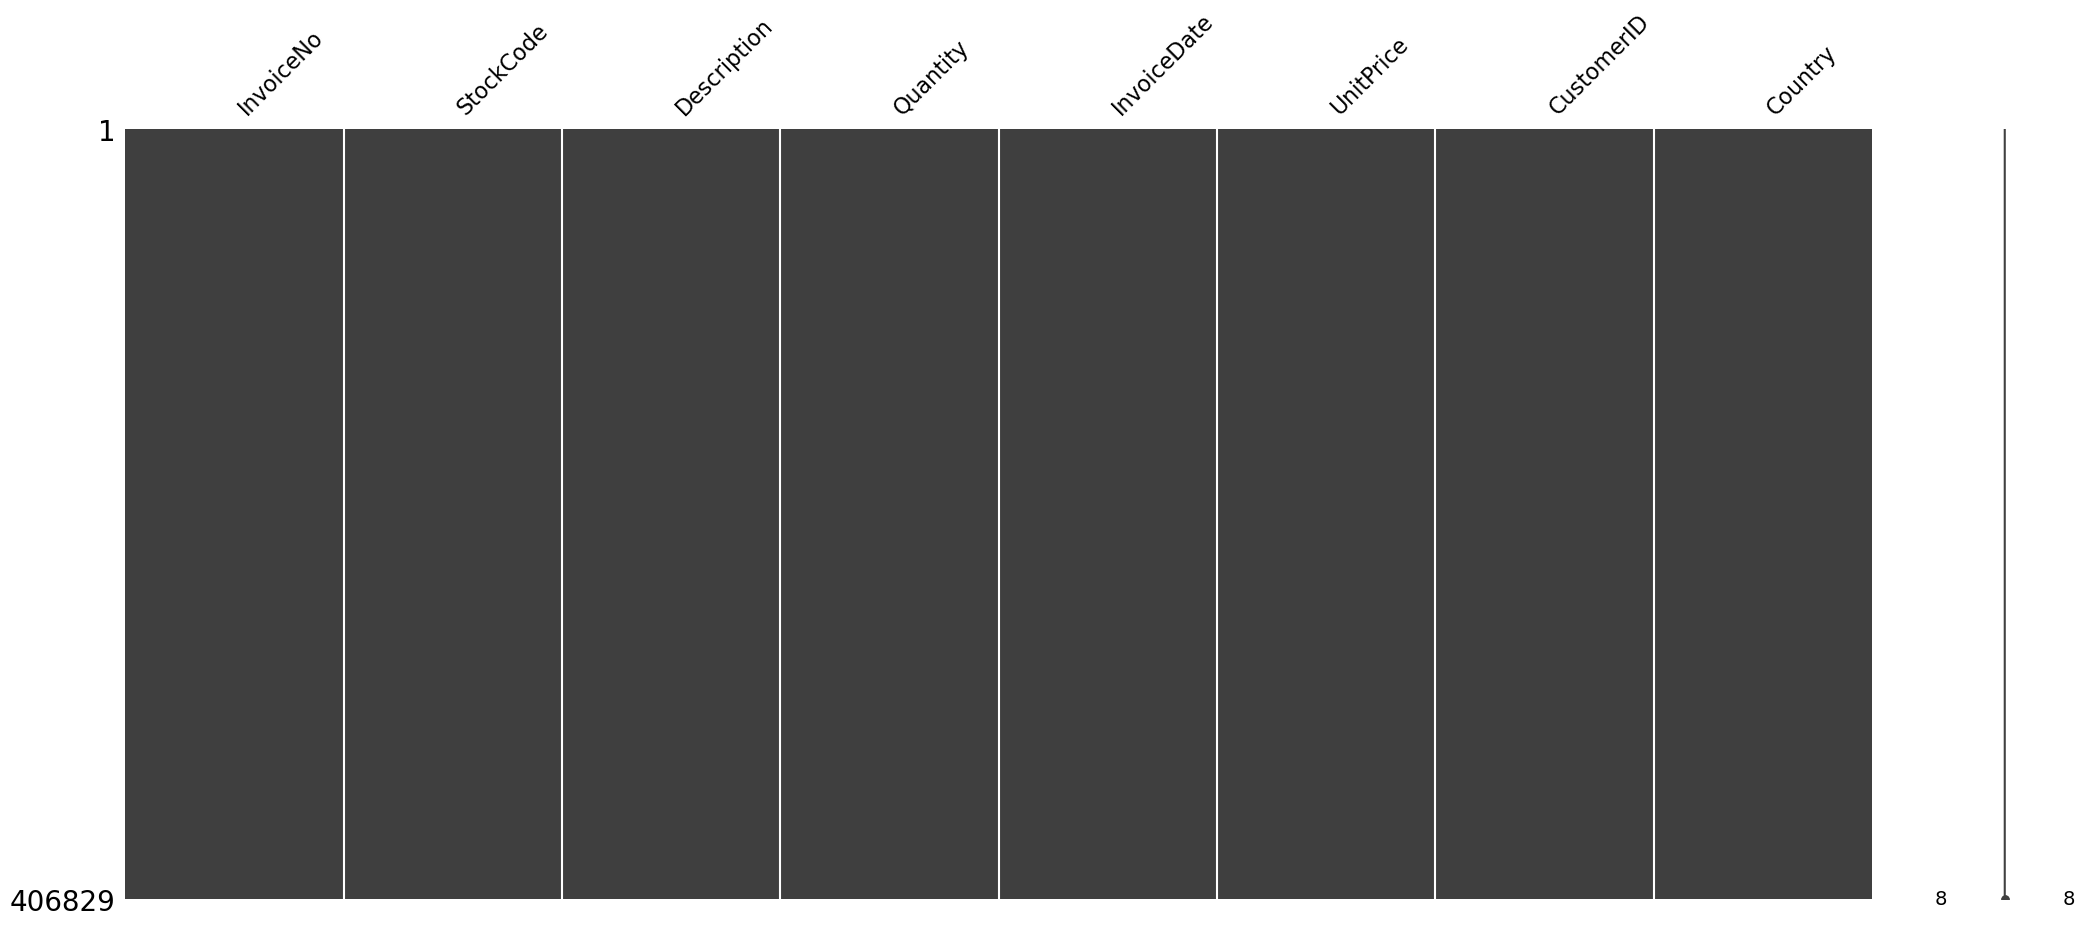

In [16]:
msno.matrix(df_ECom_cleaned)

## 1.3 Prepare the data

In [19]:
# Create a Total Spend column 
df_ECom_cleaned["Total_Spend"] = df_ECom_cleaned["Quantity"] * df_ECom_cleaned["UnitPrice"]

/var/folders/6d/l8cxbvrd4fvc1_gh7ccn62g80000gn/T/ipykernel_44423/3259848580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ECom_cleaned["Total_Spend"] = df_ECom_cleaned["Quantity"] * df_ECom_cleaned["UnitPrice"]


In [20]:
# Convert InvoiceDate to datetime
df_ECom_cleaned["InvoiceDate"] = pd.to_datetime(df_ECom_cleaned["InvoiceDate"])

/var/folders/6d/l8cxbvrd4fvc1_gh7ccn62g80000gn/T/ipykernel_44423/1640748709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ECom_cleaned["InvoiceDate"] = pd.to_datetime(df_ECom_cleaned["InvoiceDate"])


In [22]:
df_ECom_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   Total_Spend  406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


## 2. Perform Segmentation

In [29]:
# Recency, Frequency, Monetary
import datetime as dt
snapshot_date = df_ECom_cleaned['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df_ECom_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Total_Spend': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Total_Spend': 'Monetary'})

In [30]:
# Normalize RFM 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


In [31]:
# Apply Clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)


# 3. Visualization

<Axes: >

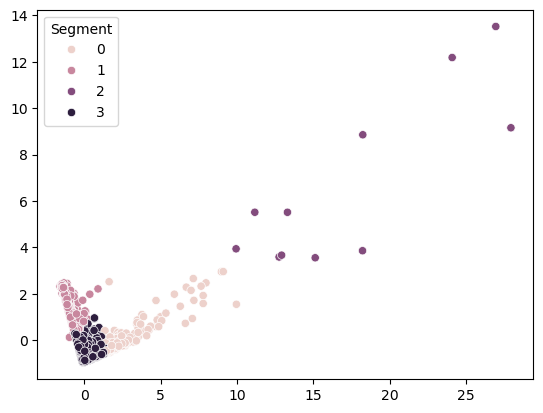

In [32]:
# Visualize with PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(rfm_scaled)

import seaborn as sns
sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], hue=rfm['Segment'])


Text(0.5, 0, 'Segment')

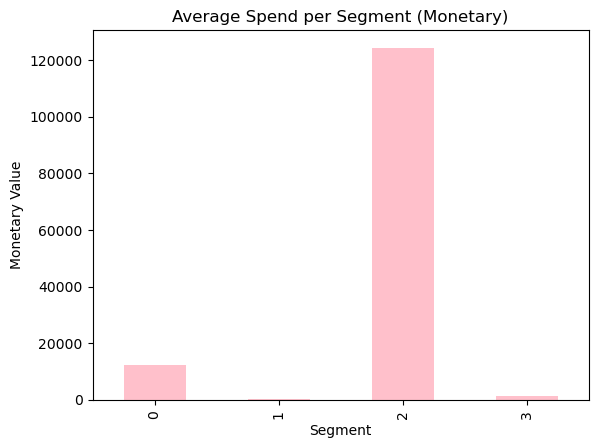

In [38]:
#Average Monetary Value per Segment 
rfm.groupby('Segment')['Monetary'].mean().plot(kind='bar', color='pink')
plt.title('Average Spend per Segment (Monetary)')
plt.ylabel('Monetary Value')
plt.xlabel('Segment')

Text(0.5, 0, 'Segment')

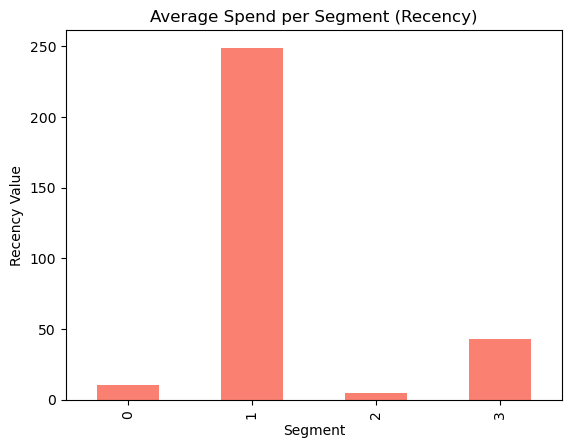

In [41]:
#Average Recency Value per Segment 
rfm.groupby('Segment')['Recency'].mean().plot(kind='bar', color='salmon')
plt.title('Average Spend per Segment (Recency)')
plt.ylabel('Recency Value')
plt.xlabel('Segment')

Text(0.5, 0, 'Segment')

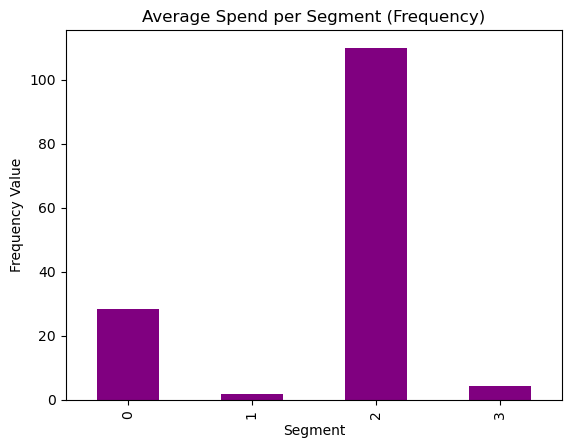

In [42]:
#Average Frequency Value per Segment 
rfm.groupby('Segment')['Frequency'].mean().plot(kind='bar', color='purple')
plt.title('Average Spend per Segment (Frequency)')
plt.ylabel('Frequency Value')
plt.xlabel('Segment')

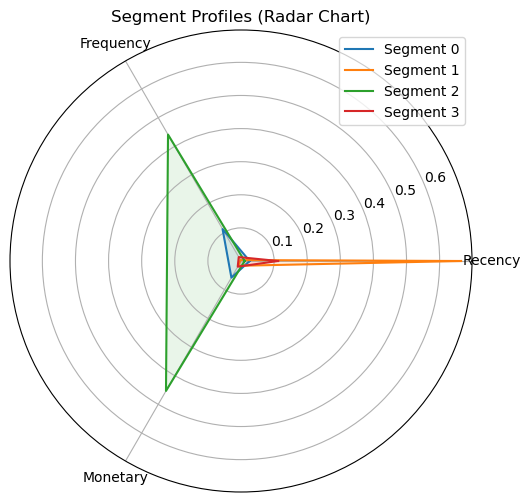

In [45]:
# Normalize RFM
rfm_norm = rfm[['Recency', 'Frequency', 'Monetary']].copy()
rfm_norm = (rfm_norm - rfm_norm.min()) / (rfm_norm.max() - rfm_norm.min())
rfm_norm['Segment'] = rfm['Segment']

# Average per segment
segment_profiles = rfm_norm.groupby('Segment').mean()

# Radar chart setup
labels = ['Recency', 'Frequency', 'Monetary']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

for i, row in segment_profiles.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=f'Segment {i}')
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.legend()
plt.title('Segment Profiles (Radar Chart)')
plt.show()
